## Исхаков Артур Радикович

#### Результат на Kaggle

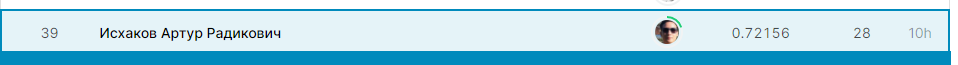

In [1]:
from IPython.display import Image
Image('result.png')

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn import model_selection
from sklearn import impute, preprocessing
from sklearn import pipeline, compose
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import linear_model, ensemble
import catboost
from sklearn import metrics

from sklearn.exceptions import NotFittedError

## Цель работы

На прошлой неделе были построенны 3 baseline-модели:
 - Логистическую регрессию
 - Случайный лес
 - Градиентный бустинг

При анализе их качества было решено сделать упор на модели, основанные на деревьях (случайный лес и градиентный бустинг). 

Предобработка данных при построении baseline-моделей заключалась  в удалении константных признаков, заполнением пропусков средними значениями у вещественных признаков и самыми популярными значениями у категориальных признаков. Далее была проведена стандартизация вещественных и кодировка категориальных данных.

В данной работе необходимо улучшить имеющиеся результаты, полученые при построении baseline-моделей. Рассмотреть различные варианты предобработки данных, произвести отбор наиболее важных признаков. 

Основной метрикой для оценки качества построенного решения является ROC-AUC.

Конечным результатом работы будет участие в соревновании на Kaggle:
https://www.kaggle.com/c/telecom-clients-prediction2

## Импортируем данные

In [3]:
data = pd.read_csv('orange_small_churn_train_data.csv')

Посмотрим на несколько строк данных:

In [4]:
print(data.shape)
data.head(5)

(18299, 232)


,ID,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,labels
0,0,NaN,NaN,NaN,NaN,NaN,3052.0,NaN,NaN,NaN,...,vr93T2a,LM8l689qOp,NaN,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN,NaN,-1.0
1,1,NaN,NaN,NaN,NaN,NaN,1813.0,7.0,NaN,NaN,...,6hQ9lNX,LM8l689qOp,NaN,ELof,xb3V,RAYp,55YFVY9,mj86,NaN,-1.0
2,2,NaN,NaN,NaN,NaN,NaN,1953.0,7.0,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,NaN,FSa2,ZI9m,ib5G6X1eUxUn6,mj86,NaN,-1.0
3,3,NaN,NaN,NaN,NaN,NaN,1533.0,7.0,NaN,NaN,...,e4lqvY0,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN,1.0
4,4,NaN,NaN,NaN,NaN,NaN,686.0,7.0,NaN,NaN,...,MAz3HNj,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN,-1.0


#### Разделим признаки на вещественные и категориальные:
Признаки, которые имеют одно уникальное значение не будем использовать, т к константные признаки не имеют смысла при построении модели. 

В начале ограничимся категориальными признаками, вариация значений которых меньше 300. Также добавим возможность отобрать признаки по количеству пропусков в них.

In [5]:
class FeatureBorder:
    
    def __init__(self, data):
        self.__data = data
        
    def choice_features(self, low, hight, num = True, cat_feature_var = 300):    
        features = self.generate_features_name(low, hight)
        result_features = []
        for var in features:
            size_feature = self.__data[var].unique().shape[0]
            if num:
                if self.detect_constant(size_feature):
                    result_features.append(var)
            else:
                if self.detect_constant(size_feature) and self.variation_feature(size_feature, cat_feature_var):
                    result_features.append(var)
        return result_features
    
    def choice_features_with_nan(self, current_features, treshold):
        features = []
        for var in current_features: 
            nan_flag = self.__data[var].isnull().any()
            if nan_flag:
                if self.__proportion_count(var, treshold):
                    features.append(var)
            else:
                features.append(var)
        return features
    
    def __proportion_count(self, var, treshold):
        return sum(self.__data[var].isnull()) / self.__data[var].shape[0] < treshold
    
    @staticmethod
    def generate_features_name(low, hight):
        return [''.join(('Var', str(i))) for i in range(low, hight)]
    
    @staticmethod
    def detect_constant(size_feature):
        return size_feature >= 2
    
    @staticmethod
    def variation_feature(size_feature, cat_feature_var):
        return size_feature < cat_feature_var  

In [6]:
feature_border = FeatureBorder(data)
num_features = feature_border.choice_features(1, 191)
cat_features = feature_border.choice_features(191, 231, num = False)

In [7]:
print('num_feaures size: {}'.format(len(num_features)))
print('cat_feaures size: {}'.format(len(cat_features)))

num_feaures size: 174
cat_feaures size: 28


#### Оставим отложенную выборку для тестирования качества модели:

В целевой функции есть один пропуск, удалим этот объект из данных:

In [8]:
labels = data['labels']
print(labels.isnull().value_counts())
labels.iloc[-3:]

False    18298
True         1
Name: labels, dtype: int64


18296   -1.0
18297   -1.0
18298    NaN
Name: labels, dtype: float64

In [9]:
data.drop(labels.index[-1], axis = 0, inplace = True)

Доля классов в данных:

In [10]:
print('Отток: %.4f' % (data[data.labels == 1].labels.count().item() / data.labels.shape[0]))
print('Не Отток: %.4f' % (data[data.labels != 1].labels.count().item() / data.labels.shape[0]))

Отток: 0.0753
Не Отток: 0.9247


Разделим данные на тренировочную и тестовую части. На тренировочной части будем обучать модель, а на тестовой смотреть на ее качество. 

Классы в данных несбалансированны, поэтому при разделении передадим в функцию train_test_split параметр stratify = labels для разделения объектов в выборках поровну из каждого класса на обучение и тест.

In [11]:
labels = data['labels']
labels = np.array(list(map(lambda x: int(x) if x is not np.nan else x, labels)))

(data_train, data_test, 
 y_train, y_test) = model_selection.train_test_split(data, labels, 
                                                    test_size = 0.20, 
                                                    stratify = labels,
                                                    random_state = 1)


print('data_train size: {}'.format(data_train.shape))
print('labels_train size: {}'.format(y_train.shape))
print('')
print('data_test size: {}'.format(data_test.shape))
print('labels_test size: {}'.format(y_test.shape))

data_train size: (14638, 232)
labels_train size: (14638,)

data_test size: (3660, 232)
labels_test size: (3660,)


#### Предобработка данных:

Создадим **класс SimplePreprocessing** для предобработки данных. Класс является наследником BaseEstimator и TransformerMixin и в нем определены методы fit, transform и fit_transform, что позволяет использовать данный класс в пайплайнах sklearn.   

Класс включает в себя отдельную предобработку вещественных и категориальных признаков. Обработка вещественных признаков включает в себя заполнение пропусков нулями и стандартизацию. Для категориальных признаков обработка заключается в 
заполнении пропусков клнстантными значениями и One-Hot кодирование.
    
Для работы с классом в его конструктор необходимо передать названия вещественных и категориальных признаков. Результатом работы класса является предобработанные данные в виде numpy array. 

In [12]:
class SimplePreprocessing(BaseEstimator, TransformerMixin):
    
    def __init__(self, num_features, cat_features):
        self.num_features = num_features
        self.cat_features = cat_features
        
        self.data = None
        self.fit_flag = False
    
        # pipeline for numeric features
        self.num_preprocessing = pipeline.Pipeline(steps = [
            ('num', impute.SimpleImputer(strategy = 'mean')), # strategy = 'constant', fill_value = 0
            ('num_scaler', preprocessing.StandardScaler())
        ])
        # pipeline for numeric features
        self.cat_preprocessing = pipeline.Pipeline(steps = [
            ('cat', impute.SimpleImputer(strategy = 'constant')), # 'most_frequent'
            ('cat_encoder', preprocessing.OneHotEncoder(handle_unknown = 'ignore', sparse = False))
        ])
    
        # transformer for impute NaN and preprocessing features
        self.data_preprocessing = compose.ColumnTransformer(transformers = [
            ('num_features', self.num_preprocessing, self.num_features),
            ('cat_features', self.cat_preprocessing, self.cat_features)
        ])
        
    def fit(self, X, y = None):
        self.data_preprocessing = self.data_preprocessing.fit(X)
        self.fit_flag = True
        return self
        
    def transform(self, X, y = None):
        if self.fit_flag == False:
            raise NotFittedError('This SimplePreprocessing instance is not fitted yet.')
        self.data = self.data_preprocessing.transform(X)
        return self.data
    
    def fit_transform(self, X, y = None):
        self.fit(X)
        return self.transform(X)

#### Кросс-валидация
Классы в задаче несбалансированы, поэтому будем использовать stratified k-fold с разбиением на 4 фолда. 

In [13]:
class CrossValidation:
    
    def __init__(self):
        self.cv = model_selection.StratifiedKFold(n_splits = 4, random_state = 1)
        
    def cross_validation(self, model, data, y, scoring = 'roc_auc'):
        result = model_selection.cross_val_score(model, data, y, 
                                                 cv = self.cv, scoring = scoring,  
                                                 n_jobs = -1)
        return result
    
    def cross_validation_for_catboost(self, model, feature_transformer, data, y, metrics):
        result = []
        for train_indices, test_indices in self.cv.split(data, y):
            current_model = model
            transformer = feature_transformer
            # train data and target
            data_train = transformer.fit_transform(data.iloc[train_indices])
            y_train = y[train_indices]
            # tets data and target
            data_test = transformer.transform(data.iloc[test_indices])
            y_test = y[test_indices]
            
            # fit on train data and predict on dat test
            current_model.fit(data_train, y_train, verbose = False)
            if metrics.__name__ == 'roc_auc_score':
                result.append(metrics(y_test, current_model.predict_proba(data_test)[:, 1]))
            else:
                result.append(metrics(y_test, current_model.predict(data_test)))
        return result

## Случайный лес

Пайплайн из предобработки данных и случайного леса. Параметры случайного леса оставим по умолчанию и посмотрим на качество на кросс-валидации. Далее выполним подбор количества деревьев, которые используются в случайном лесе. Воспользуемся поиском по сетке.

In [15]:
random_forest = pipeline.Pipeline(steps = [
    ('preprocessing', SimplePreprocessing(num_features, cat_features)), 
    ('forest', ensemble.RandomForestClassifier(class_weight = 'balanced',
                                               n_jobs = -1, 
                                               random_state = 1))
])

In [16]:
roc_auc_score_forest = CrossValidation().cross_validation(random_forest, data_train, y_train)


print('roc_auc_score: {}  mean: {}'.format(roc_auc_score_forest, 
                                          round(roc_auc_score_forest.mean(), 4)))

roc_auc_score: [0.67459132 0.65095601 0.67541049 0.65435687]  mean: 0.6638


In [17]:
forest_grid_params = {
    'forest__min_samples_split': [i for i in range(30, 36)],
    'forest__min_samples_leaf': [i for i in range(5, 10)]
}


forest_grid_search = model_selection.GridSearchCV(random_forest, 
                                                  param_grid = forest_grid_params,
                                                  cv = CrossValidation().cv, 
                                                  scoring = 'roc_auc', 
                                                  n_jobs = -1)

In [18]:
forest_grid_search.fit(data_train, y_train);

In [19]:
print('лучшие параметры: {}'.format(forest_grid_search.best_params_))
print(' ')
print('лучшее качество: {}'.format(round(forest_grid_search.best_score_, 4)))
print(' ')
print('качество на отложенной выборке: {}'.format(round(
    metrics.roc_auc_score(y_test, forest_grid_search.predict_proba(data_test)[:, 1]), 4)
))

лучшие параметры: {'forest__min_samples_leaf': 5, 'forest__min_samples_split': 33}
 
лучшее качество: 0.6912
 
качество на отложенной выборке: 0.6986


## Корреляция 
Вычислим корреляцию вещественных и категориальных признаков с целевой функцией.

**Корреляцию вещественных признаков** с целевой функцией рассчитаем как разность математический ожиданий признака при условии класса "отток" и признака при условии класса "не отток". Для интерпритации и сравнения между собой полученных значений корреляции проведем стандартизацию данных перед вычислениями. Для признаков, у которых объектов первого класса будет меньше 200 не будем вычислять корреляцию.

**Корреляцию категориальных признаков** с целевой функцией рассчитаем с помощью коэффициента V крамера. Для признаков, у которых вариация значений равна 1 не будем вычислять корреляцию.

Результатом является DataFrame с индексами в виде признаков и колонкой со значениеми корреляции признака с целевой функцией.

In [14]:
class Correlation:
    
    def __init__(self, data):
        self.__data = data
        
    def numeric_correlation(self, num_features, low_limit = 200):
        corr = []
        # scaling numerical features
        scaler = preprocessing.StandardScaler()
        data_num = pd.DataFrame(index = self.__data.index, columns = num_features, 
                                data = scaler.fit_transform(self.__data[num_features]))
        data_num['labels'] = self.__data.labels
        for var in num_features:
            if self.count_element_first_class(var, low_limit):
                corr.append(data_num[data_num['labels'] == 1][var].mean() - 
                            data_num[data_num['labels'] != 1][var].mean())
            else:
                corr.append(np.nan)
        data_num_correlation = pd.DataFrame(index = num_features, 
                                            columns = ['correlation'],
                                            data = corr)
        return data_num_correlation
    
    def categorical_correlation(self, cat_features):
        corr = []
        for var in cat_features:
            if self.__data[var].value_counts().shape[0] < 2:
                corr.append(np.nan)
                continue
            table = pd.crosstab(self.__data[var], self.__data['labels'])
            stat, _, _, _ = stats.chi2_contingency(table)
            corr.append(np.sqrt(stat / table.sum().sum()))
        data_cat_correlation = pd.DataFrame(index = cat_features, 
                                columns = ['correlation'],
                                data = corr)
        return data_cat_correlation
    
    def count_element_first_class(self, var, low_limit):
        return self.__data[self.__data['labels'] == 1][var].dropna().shape[0] > low_limit

Рассчитаем корреляцию с целевой функцией для вещественных и категориальных признаков. Получим отсортированный по убыванию значений корреляции список признаков, отдельно для разных категорий признаков признаков.

Посмотрим на 10 вещественных признаков, которые наиболее сильно коррелируют с целевой функцией, и на их плотности распредения в разрезе классов и на 10 категориальных признаков 

In [15]:
data_num_correlation = Correlation(data).numeric_correlation(num_features)
num_features_corr = list(data_num_correlation.abs().sort_values(by = 'correlation', 
                                                           ascending = False).index.to_numpy())


data_cat_correlation = Correlation(data).categorical_correlation(cat_features)
cat_features_corr = list(data_cat_correlation.sort_values(by = 'correlation', 
                                                           ascending = False).index.to_numpy())

In [16]:
print('Вещественные признаки: ')
data_num_correlation.abs().sort_values(by = 'correlation', 
                                        ascending = False)[:10]

Вещественные признаки: 


,correlation
Var189,0.511358
Var73,0.270956
Var7,0.259341
Var113,0.216467
Var144,0.206605
Var126,0.192795
Var13,0.171491
Var72,0.169424
Var65,0.168546
Var74,0.148224


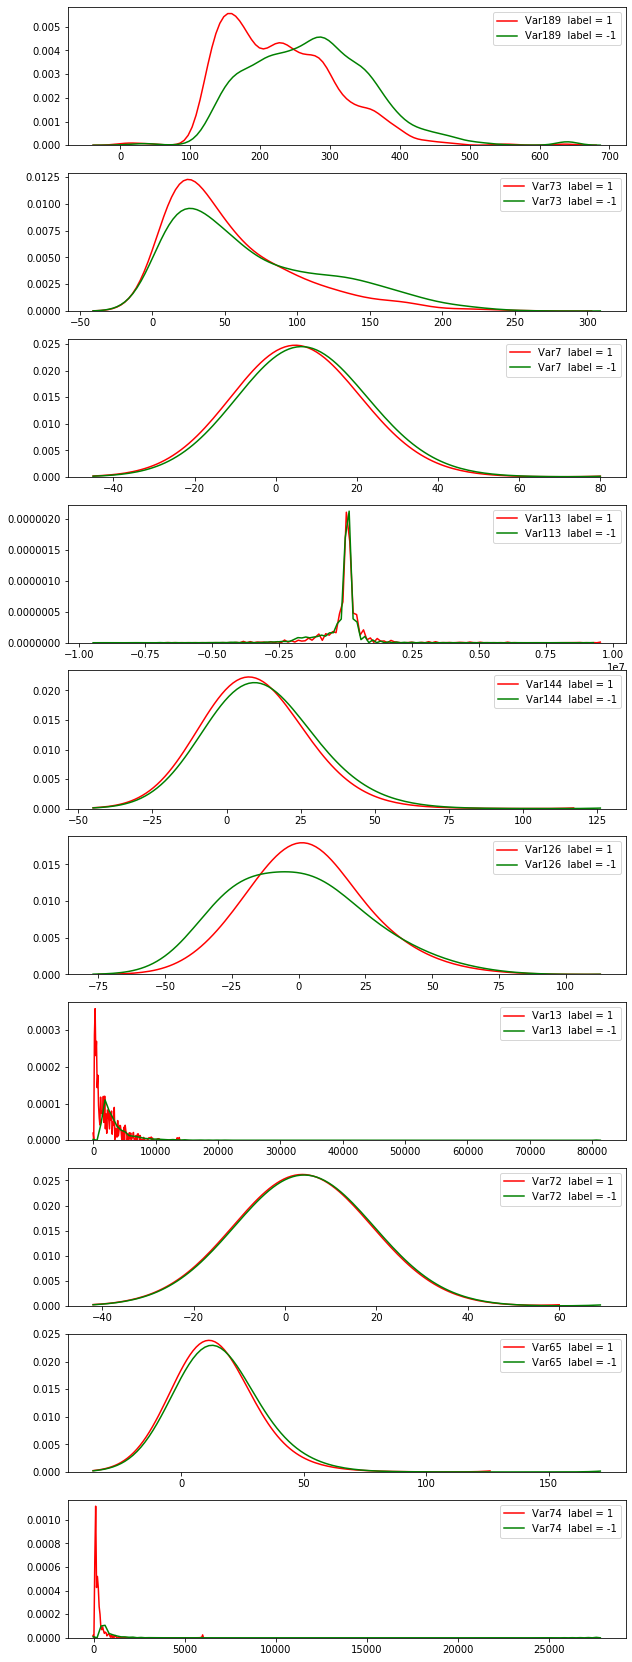

In [17]:
fig, axs = plt.subplots(10, figsize = (10, 30))
for ax, var in zip(axs, num_features_corr[:10]):
    sns.kdeplot(data[data.labels == 1][var], ax = ax, bw = 15,
                color = 'red', label = '  '.join((var, 'label = 1')));
    sns.kdeplot(data[data.labels != 1][var], ax = ax, bw = 15,
                color = 'green', label = '  '.join((var, 'label = -1')));

Видны небольшие различия в распредлениях плотностей вещественных признаков по целевой функции. Предположим, что данные признаки будут наиболее важными для модели.

In [18]:
print('Категориальные признаки:')
data_cat_correlation.sort_values(by = 'correlation', 
                                    ascending = False)[:10]

Категориальные признаки:


,correlation
Var197,0.111692
Var212,0.096354
Var204,0.086667
Var206,0.083391
Var205,0.080275
Var228,0.078510
Var193,0.076070
Var207,0.065424
Var210,0.059768
Var227,0.055818


Оставим 10 вещественных и 20 категориальных признаков, имеющих наибольшую корреляцию с целевой функцией.

Обучим случайный лес с лучшими параметрами на этих признаках и посмотрим на изменение качества на отложенной выборке.

In [25]:
random_forest = pipeline.Pipeline(steps = [
    ('preprocessing', SimplePreprocessing(num_features_corr[:10], cat_features_corr[:20])), 
    ('forest', ensemble.RandomForestClassifier(class_weight = 'balanced',
                                               n_estimators = 500,
                                               min_samples_split = 35,
                                               min_samples_leaf = 5,
                                               n_jobs = -1, 
                                               random_state = 1))
])

In [26]:
random_forest.fit(data_train, y_train)
print('качество на отложенной выборке: {}'.format(round(
    metrics.roc_auc_score(y_test, random_forest.predict_proba(data_test)[:, 1]), 4)
))

качество на отложенной выборке: 0.7224


Качество по метрике ROC_AUC на отложенной выборке увеличилось примерно на 0.03. Это показывает, что отбор признаков на основе корреляции с целевой функцией дает прирост в качестве, т к мы убрали неинформативные и оставили только важные для модели признаки.

## Сэмплирование

Классы "отток" и "не отток" в наших данных несбалансированы. Для балансировки классов воспользуемся двумя подходами. 

Первый подход заключается в рандомном удалении объектов мажоритарного класса. Метод undersampling класса Sampling.

Второй подход заключается в дублировании объектов миноритарного класса. Метод oversampling класса Sampling.

Получим новые подвыборки с помощью двух методов и посмотрим на качество на отложенной выборке.

In [19]:
class Sampling:
    
    def __init__(self, data, y):
        self.__data = data
        self.__y = y
        
    def undersampling(self, difference_classes):
        index_majority_class = self.__data[self.__data.labels != 1].index.to_numpy()
        size = index_majority_class.shape[0] - difference_classes
        index_for_drop = np.random.choice(index_majority_class, size, replace = False)
        data_undersampling = self.__data.drop(index_for_drop)
        return data_undersampling, data_undersampling['labels']
    
    def oversampling(self, difference_classes):
        index_minority_class = self.__data[self.__data.labels == 1].index.to_numpy()
        data_oversampling = self.__data
        class_relationint = int(difference_classes * self.__data[self.__data.labels != 1].shape[0] / self.__data[self.__data.labels == 1].shape[0])
        for i in range(class_relationint):
            data_oversampling= pd.concat([data_oversampling, self.__data.loc[index_minority_class]])            
        return data_oversampling, data_oversampling['labels']

In [20]:
sampling = Sampling(data_train, y_train)


size = data_train[data_train.labels == 1].shape[0]
data_train_undersampling, y_train_undersampling = sampling.undersampling(size)


data_train_oversampling, y_train_oversampling = sampling.oversampling(0.9)

Метод Undersampling:

In [29]:
random_forest.fit(data_train_undersampling, y_train_undersampling)
print('качество на отложенной выборке: {}'.format(round(
    metrics.roc_auc_score(y_test, random_forest.predict_proba(data_test)[:, 1]), 4)
))

качество на отложенной выборке: 0.7145


Метод Oversampling:

In [30]:
random_forest.fit(data_train_oversampling, y_train_oversampling)
print('качество на отложенной выборке: {}'.format(round(
    metrics.roc_auc_score(y_test, random_forest.predict_proba(data_test)[:, 1]), 4)
))

качество на отложенной выборке: 0.7181


Оба метода дают качество ниже, чем такая же модель, но с исходными данными. Минус подхода дублирования объектов миноритарного класса заключается в значительном снижении скорости обучения, т к вырастает количество объектов в выборке. В подходе удаления объектов мажоритарного класса наоборот скорость обучения увеличивается.

## Градиентный бустинг

В качестве градиентного бустинга будем использовать **catboost**. 

При построении модели будем использовать балансировку классов, исходя из доли каждого класса в выборке. Также добавим параметр 
early_stopping_rounds = 200, что значит остановку обучения при ухудшении ошибки на тестовой части на 200 итерациях подряд.

В качестве исходных признаков будем использовать 10 вещественных и 25 категориальных признаков, которые имеют наиболее сильную корреляцию с целевой функцией. После построения модели посмотрим на наиболее важные для нее признаки и сравним их с отбораными посредством корреляции.

Т к в catboost отсутствует возможность использовать его в пайплайнах sklearn, поэтому всю предобработку данных будем делать отдельно. Напишем свою кросс-валидацию, в которой реализуем разделение данных на тренирочные и тестовые. На тренировочной части 
будем обучать алгоритмы предобработки данных и сам классификатор, а на тестовой части будем использовать уже обученные алгоритмы для трансформации данных и измерения качества классификатора на этой части. Сделано это во избежании утечки данных, т к предобработка работает отдельно от классификатора. В качестве стратегии разделения данных в кросс-валидации будем использовать stratified k-fold с разбиением на 4 фолда.

В качестве предобработки будем использовать подходы, которые дали лучший результат при построении случайного леса. Пропуски в вещественных признаках заполним средними значениями, а в категориальных признаках заполним константными значениями.  

In [21]:
class DataForCatboost(BaseEstimator, TransformerMixin):
    
    def __init__(self, num_features, cat_features):
        self.num_features = num_features
        self.cat_features = cat_features
        self.data = None
        self.size_data = 0
        
    def fit(self, X, y = None):
        self.size_data = X.shape[0]
        self.data = pd.DataFrame(columns = self.num_features + self.cat_features, 
                                data = X)
        return self
    
    def transform(self, X, y = None):
        if self.size_data == X.shape[0] or self.size_data == 0:
            return self.data
        else: 
            current_data = pd.DataFrame(columns = self.num_features + self.cat_features, 
                                data = X)
            return current_data
    
    def fit_transform(self, X, y = None):
        self.fit(X)
        return self.transform(X)

In [22]:
num_preprocessing = pipeline.Pipeline(steps = [
    ('num', impute.SimpleImputer(strategy = 'mean'))
])
cat_preprocessing_for_catboost = pipeline.Pipeline(steps = [
    ('cat_impute', impute.SimpleImputer(strategy = "constant"))
])


# трансформер для заполнения пропусков и преобразования вещественных признаков
features_for_catboost = compose.ColumnTransformer(transformers = [
    ('num_features', num_preprocessing, num_features_corr[:10]), 
    ('cat_features', cat_preprocessing_for_catboost, cat_features_corr[:25]) 
])


# итоговый pipeline для предобработки данных
all_features = pipeline.Pipeline(steps = [
    ('feature', features_for_catboost), 
    ('data', DataForCatboost(num_features_corr[:10], cat_features_corr[:25]))
])

In [23]:
catboost_classifier = catboost.CatBoostClassifier(n_estimators = 850,
                                                  class_weights = [0.9, 0.1], eval_metric = 'AUC', 
                                                  cat_features = cat_features_corr[:25])

Посмотрим на качество на кросс-валидации:

In [24]:
roc_auc_score_catboost = CrossValidation().cross_validation_for_catboost(catboost_classifier,
                                                       all_features, data_train, y_train,  
                                                       metrics = metrics.roc_auc_score)


print('roc_auc_score: {}  mean: {}'.format(roc_auc_score_catboost, 
                                          round(np.array(roc_auc_score_catboost).mean(), 4)))

roc_auc_score: [0.7362117552334944, 0.7345307842532635, 0.722685364281109, 0.7129561573178594]  mean: 0.7266


Обучим классификатор, посмотрим на качество на отложенной выборке и на важность признаков:

In [36]:
data_train_for_catboost = all_features.fit_transform(data_train)
data_test_for_catboost = all_features.transform(data_test)

catboost_classifier.fit(data_train_for_catboost, y_train,
                        eval_set = (data_test_for_catboost, y_test),
                        early_stopping_rounds = 200,
                        verbose = False, plot = True);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [37]:
print('качество на отложенной выборке: {}'.format(round(
    metrics.roc_auc_score(y_test, 
                    catboost_classifier.predict_proba(data_test_for_catboost)[:, 1]), 5)
))

качество на отложенной выборке: 0.75658


Посмотрим на наиболее важные признаки для модели:

In [27]:
data_features_important = catboost_classifier.get_feature_importance(prettified = True)


important_features_catboost = catboost_classifier.get_feature_importance(prettified = True)['Feature Id'].to_numpy()
num_important_features_catboost, cat_important_features_catboost = [], []
type_feature = []
for var in important_features_catboost:
    if var in num_features:
        num_important_features_catboost.append(var)
        type_feature.append('numeric')
    else:
        cat_important_features_catboost.append(var)
        type_feature.append('categorical')
        

data_features_important['type Feature'] = type_feature

In [28]:
data_features_important

,Feature Id,Importances,type Feature
0,Var126,37.494282,numeric
1,Var189,8.100237,numeric
2,Var218,7.460972,categorical
3,Var113,6.668041,numeric
4,Var73,5.778674,numeric
5,Var212,3.681232,categorical
6,Var13,3.455149,numeric
7,Var74,3.015917,numeric
8,Var205,2.683125,categorical
9,Var211,1.987394,categorical


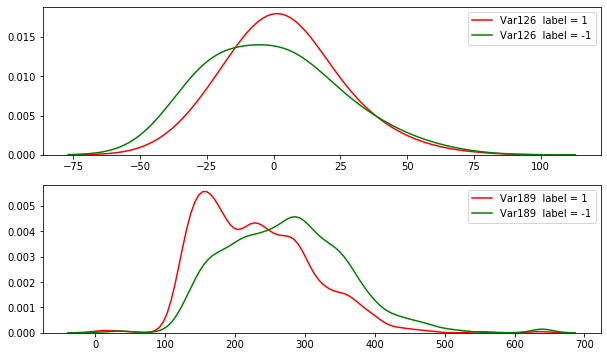

In [29]:
fig, axs = plt.subplots(2, figsize = (10, 6))
for ax, var in zip(axs, num_important_features_catboost[:2]):
    sns.kdeplot(data[data.labels == 1][var], ax = ax, bw = 15,
                color = 'red', label = '  '.join((var, 'label = 1')));
    sns.kdeplot(data[data.labels != 1][var], ax = ax, bw = 15,
                color = 'green', label = '  '.join((var, 'label = -1')));

Вещественные и категориальные признаки, наиболее важные для модели, имеют сильную корреляцию с целевой функцией. Вещественные признаки Var126 и Var189, являющиеся наиболее значими для построенного классификатора, имеют значимые различия в распредлениях плотностей в разрезе классов.

---

## Выводы

**Целью** данной работы было улучшение baseline-моделей, построенных на прошлой неделе, а также участие в соревновании на Kaggle.

В начале решения было проведено разделение данных на тренировочную и тестовую часть, на которой и оценивалось качество построенных моделей.

**Предобработка данных** заключалась в следующем:
  - Удаление константных признаков  
  - Заполнение пропусков у вещественных  и категориальных признаков
  - Кодирование категориальных данных с помощью OneHot encoder

Лучший результат показала стратегия заполнения пропусков средними значениями у вещественных признаков и константантными у категориальных.


Так как классы в данных были несбалансированны, то были применены следующие методы для **балансировки классов**:
   - балансировка классов на уровне модели
   - рандомном удалении объектов мажоритарного класса (Random Undersampling)
   - дублировании объектов миноритарного класса (Oversampling)

Балансировка классов на уровне модели показала лучший результат в ходе решения. Overrsampling дал чуть меньшее качество и скорость обучения снизилась значительно, т к было увеличенно количество объектов в выборке. Random Undersampling показал хучшее качество среди этих трех подходов.

**Отбор признаков** был сделан на основе корреляции признаков с целевой функцией. **Для вещественных признаков** корреляция была рассчитана как разность математических ожиданий признака при условии класса "отток" и признака при условии класса "не отток". **Для категориальных признаков** корреляция была расчитана с помощью коэффициента V крамера. Данный подход отбора признаков дал существенное увеличение в качестве. Также было установленно, что признаки имеющие наибольшую корреляцию с целевой функцией оказались наиболее важными для построенной модели градиентного бустинга.

В качестве моделей были выбраны **случайный лес** и **градиентный бустинг**, т к именно они показали лучший результат при построении baseline-моделей.

**Лучшее качество** моделей на отложенной выборке:
  - **Случайный лес:**  ROC-AUC = 0.7224
  - **Градиентный бустинг:** ROC-AUC = 0.7566
  
В качестве итоговой модели на данном этапе был выбран Градиентный бустинг.

---

## Предсказания для Kaggle

In [102]:
import csv

In [103]:
test_data = pd.read_csv('orange_small_churn_test_data.csv')

In [104]:
print(test_data.shape)
test_data.head()

(10000, 231)


,ID,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,0,NaN,NaN,NaN,NaN,NaN,1225.0,7.0,NaN,NaN,...,zCkv,APgdzOv,jySVZNlOJy,NaN,ELof,xb3V,6fzt,Zy3gnGM,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,896.0,14.0,NaN,NaN,...,oslk,IIvC99a,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,791.0,7.0,NaN,NaN,...,oslk,6YSocsg,LM8l689qOp,NaN,kG3k,rgKb,RAYp,F2FyR07IdsN7I,mj86,NaN
3,3,NaN,NaN,NaN,NaN,NaN,2296.0,7.0,NaN,NaN,...,oslk,5nQ7A2G,jySVZNlOJy,NaN,kG3k,rgKb,RAYp,F2FyR07IdsN7I,am7c,NaN
4,4,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,...,oslk,MI8s5nE,LM8l689qOp,NaN,NaN,7P5s,RAYp,F2FyR07IdsN7I,NaN,NaN


In [105]:
test_data['labels'] = [i for i in range(test_data.shape[0])]

In [106]:
predict_proba = catboost_classifier.predict_proba(
                            all_features.transform(test_data))[:, 1]
result = list(map(lambda x: (x[0], x[1]), 
                  zip(test_data.index.to_numpy(), predict_proba)))

In [107]:
filename = 'prediction_.csv'
header = [('Id','result')]

with open(filename, "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(header)
    writer.writerows(result)